## Load all the necessary packages and clone the github repo for data and functions

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/JordanFoss/STAT3007_Project.git
%cd STAT3007_Project/
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import scipy
import numpy as np
import librosa
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.autograd import Variable
import pandas as pd
import glob
import os
from librosa import display
from torchsummary import summary

from IPython.display import Audio
!pip install colorednoise as cn
import pre_process
import data_loading
from CNN_Model import * 
from data_loading import *
from Model_Functions import *

Cloning into 'STAT3007_Project'...
remote: Enumerating objects: 4098, done.
remote: Counting objects: 100% (376/376), done.
remote: Compressing objects: 100% (297/297), done.
remote: Total 4098 (delta 174), reused 236 (delta 77), pack-reused 3722
Receiving objects: 100% (4098/4098), 685.38 MiB | 27.32 MiB/s, done.
Resolving deltas: 100% (759/759), done.
Checking out files: 100% (2810/2810), done.
/content/STAT3007_Project
  Created wheel for colorednoise: filename=colorednoise-1.1.1-cp37-none-any.whl size=3983 sha256=a7342cff3dc40b32f3c88726a730b2768f13d1718b89c89990316be6b5dcebf4
  Stored in directory: /root/.cache/pip/wheels/84/be/f3/3e7e1c80ebab3f6f0dbd3e34e787b902d2280d66706485fef4
Successfully built colorednoise


## Load in the clean data from the github repo

In [3]:
#X = torch.tensor(X)
import scipy.io
mat = scipy.io.loadmat('/content/STAT3007_Project/jet.mat')
jet = mat['ans']
X,y = data_loading.load_samples(os.getcwd())
X = np.array(X)
X = X.reshape(X.shape[0],1,X.shape[1],X.shape[2])
RGB = Make_All_RGB(X,jet)
RGB = torch.tensor(RGB)
y = torch.tensor(y)
data_sets = data_loading.load_sets(RGB,y,train_ratio=[0.8], seed = [10])
data_train, data_test = data_sets[0]

## Load in the noisy data from the github repo

In [ ]:
#Import all the noisy data
noisy_data_train = np.load('/content/drive/MyDrive/STAT3007 project/train_test_split_snr40/noisy_train_RGB.npy')
noisy_data_test = np.load('/content/drive/MyDrive/STAT3007 project/train_test_split_snr40/noisy_test_RGB.npy')
noisy_targets_train = np.load('/content/drive/MyDrive/STAT3007 project/train_test_split_snr40/target_train_snr40.npy')
noisy_targets_test = np.load('/content/drive/MyDrive/STAT3007 project/train_test_split_snr40/target_test_snr40.npy')

noisy_data_train = torch.tensor(noisy_data_train)
noisy_data_test = torch.tensor(noisy_data_test)

noisy_targets_train = torch.tensor(noisy_targets_train)
noisy_targets_test = torch.tensor(noisy_targets_test)

wrapper_train = DatasetWrapper(noisy_data_train, noisy_targets_train)
wrapper_test = DatasetWrapper(noisy_data_test, noisy_targets_test)
data_train, data_test = wrapper_train, wrapper_test

# Train and test the model

In [5]:
# hyperparameters:
nepoch = 50
lr = 0.01
momentum = 0.2
optimiser = 'SGD'
loss = nn.CrossEntropyLoss()

torch.manual_seed(69)
CNN = ConvNet_RGB(channels = 3)
conv_LSTM = LRCN(CNN)
trained_net,avg_loss, avg_acc, test_loss, test_acc = train_model(data_train, data_test, conv_LSTM, loss, nepoch=nepoch, momentum = momentum ,batch_size = 10,lr = lr, use_cuda = True, print_output = False, optimiser = optimiser)

KeyboardInterrupt: ignored

In [ ]:
# Create the Confusion Matrix
X_test,y_test = data_test.get_data()
X_test = X_test.type(torch.FloatTensor).to(torch.device('cpu'))
trained_net = trained_net.to(torch.device('cpu'))
pred = trained_net(X_test)
y_pred = CNN_Model.classification(pred)
import sklearn
labels = ['Calm', 'Happy', 'Sad', 'Angry', 'Suprised']
confusion = sklearn.metrics.confusion_matrix(y_test.detach().numpy(), y_pred)
thing = sklearn.metrics.ConfusionMatrixDisplay(confusion, display_labels=labels)
thing.plot(values_format='.5g')

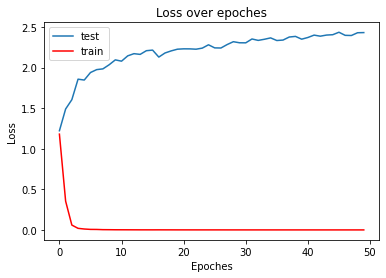

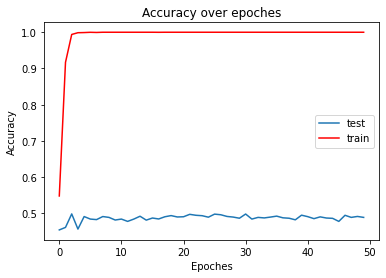

In [ ]:
#Create the Loss and accuracy graphs
epoches = [i for i in range(nepoch)]

fig = plt.figure()
plt.plot(epoches,test_loss, label = 'test')
plt.plot(epoches,avg_loss, label = 'train', color = 'r')
plt.title('Loss over epoches')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend()

fig = plt.figure()
plt.plot(epoches,test_acc, label = 'test')
plt.plot(epoches,avg_acc, label = 'train', color = 'r')
plt.title('Accuracy over epoches')
plt.xlabel('Epoches')
plt.ylabel('Accuracy')
plt.legend()
